In [ ]:
#For each image, extract a 128×128 patch from the land_cover.tif centered at the image's coordinate

In [2]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.3 MB/s eta 0:00:00


In [11]:
import rasterio

In [12]:
with rasterio.open("worldcover_bbox_delhi_ncr_2021.tif") as src:
    bounds = src.bounds
    crs = src.crs
    print("Raster CRS:", crs)
    print("Raster bounds (lon/lat):", bounds)

Raster CRS: EPSG:4326
Raster bounds (lon/lat): BoundingBox(left=76.84991666666667, bottom=28.2, right=77.65008333333334, top=29.0)


In [13]:
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
import numpy as np
import matplotlib.pyplot as plt


In [14]:
coordinates = [(77.2, 28.6), (77.4, 28.8)]

In [15]:
PATCH_SIZE = 128
HALF_PATCH = PATCH_SIZE // 2

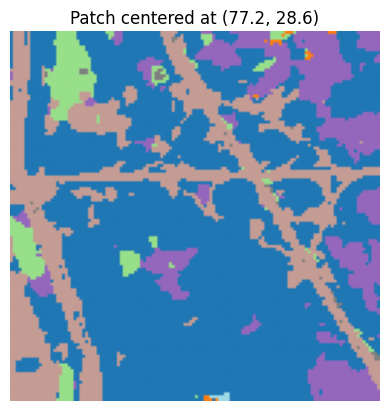

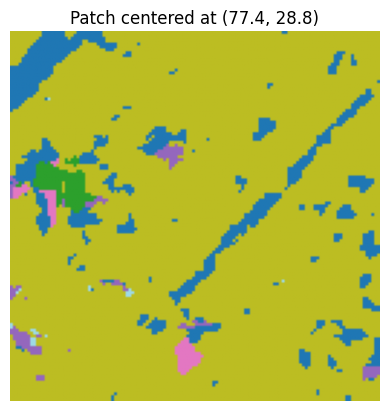

Successfully extracted 2 patches.


In [16]:
patches = [] # Initialize an empty list to store patches
with rasterio.open('worldcover_bbox_delhi_ncr_2021.tif') as src:
    transform = src.transform
    crs = src.crs
    data = src.read(1) # Read the entire band data once if needed for other purposes, though not strictly required for windowed reads

    for lon, lat in coordinates:
        # Convert world coordinates to pixel coordinates
        col, row = src.index(lon, lat)

        # Define window boundaries
        row_start = row - HALF_PATCH
        col_start = col - HALF_PATCH

        # Ensure we are within raster bounds
        if (row_start < 0 or col_start < 0 or
            row_start + PATCH_SIZE > src.height or
            col_start + PATCH_SIZE > src.width):
            print(f"Skipping coordinate {(lon, lat)}: patch exceeds bounds.")
            continue

        # Read the window (patch)
        window = Window(col_start, row_start, PATCH_SIZE, PATCH_SIZE)
        try:
            patch = src.read(1, window=window)
            patches.append(patch)
            # Optional: Display patch
            plt.imshow(patch, cmap='tab20')
            plt.title(f"Patch centered at ({lon}, {lat})")
            plt.axis('off')
            plt.show()
        except rasterio.errors.WindowError as e:
            print(f"Could not extract patch for coordinates ({lon}, {lat}): {e}")

if patches:
    print(f"Successfully extracted {len(patches)} patches.")
else:
    print("No patches were extracted for the given coordinates and patch size.")

In [17]:
#Assign a label using the mode (most frequent) land cover class in the patch

In [18]:
import numpy as np



In [24]:
def get_mode_label(patch):
    # Flatten the 2D patch to 1D array
    flat = patch.flatten()

    valid_pixels = flat[flat > 0]

    if len(valid_pixels) == 0:
        return -1  # or a special code for "no label"

    # Get the most frequent value
    mode_class = np.bincount(valid_pixels).argmax()
    return mode_class

In [20]:
label = get_mode_label(patch)
print(f"Label assigned (most frequent class): {label}")


Label assigned (most frequent class): 50


In [21]:
# Map ESA class codes to 11 standardized labels

In [22]:
import rasterio
import numpy as np

In [23]:
# Load raster file
with rasterio.open("worldcover_bbox_delhi_ncr_2021.tif") as src:
    band1 = src.read(1)  # Read first band
    unique_codes = np.unique(band1)

# Map codes to labels
print("ESA Code → Standardized Label:")
for code in unique_codes:
    label = esa_to_label.get(code, "Unknown")
    print(f"{code} → {label}")

ESA Code → Standardized Label:
0 → Unknown
10 → Forest
20 → Shrubland
30 → Grassland
40 → Cropland
50 → Built-up
60 → Barren
80 → Water
90 → Wetlands


In [33]:
# Perform a 60/40 train-test split randomly. Visualize class distribution and discuss balance.

In [29]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import random
from collections import Counter

In [28]:
PATCH_SIZE = 128
NUM_SAMPLES = 500
NODATA_VAL = 0

In [30]:
def extract_patch(dataset, center_row, center_col, size=PATCH_SIZE):
    half = size // 2
    row_start = center_row - half
    col_start = center_col - half
    row_end = center_row + half
    col_end = center_col + half

    patch = np.full((size, size), NODATA_VAL, dtype=dataset.dtypes[0])
    win_row_start = max(0, row_start)
    win_col_start = max(0, col_start)
    win_row_end = min(dataset.height, row_end)
    win_col_end = min(dataset.width, col_end)

    read_window = rasterio.windows.Window.from_slices(
        (win_row_start, win_row_end),
        (win_col_start, win_col_end)
    )

    read_data = dataset.read(1, window=read_window)

    row_offset = win_row_start - row_start
    col_offset = win_col_start - col_start
    patch[
        row_offset:row_offset + read_data.shape[0],
        col_offset:col_offset + read_data.shape[1]
    ] = read_data

    return patch

def get_dominant_class(patch, nodata=NODATA_VAL, min_valid_ratio=0.7):
    valid = patch[patch != nodata]
    if len(valid) < min_valid_ratio * patch.size:
        return -1  # Reject due to low data
    values, counts = np.unique(valid, return_counts=True)
    if max(counts) / len(valid) < 0.5:
        return -2  # Mixed class
    return values[np.argmax(counts)]

In [31]:
with rasterio.open("worldcover_bbox_delhi_ncr_2021.tif") as src:
    H, W = src.height, src.width
    patches = []
    labels = []

    random.seed(42)
    for _ in range(NUM_SAMPLES):
        r = random.randint(PATCH_SIZE//2, H - PATCH_SIZE//2)
        c = random.randint(PATCH_SIZE//2, W - PATCH_SIZE//2)

        try:
            patch = extract_patch(src, r, c)
            label = get_dominant_class(patch)

            if label >= 0:  # Valid patch
                patches.append(patch)
                labels.append(label)
        except rasterio.errors.RasterioIOError as e:
            print(f"Skipping patch at ({r}, {c}) due to read error: {e}")
            continue

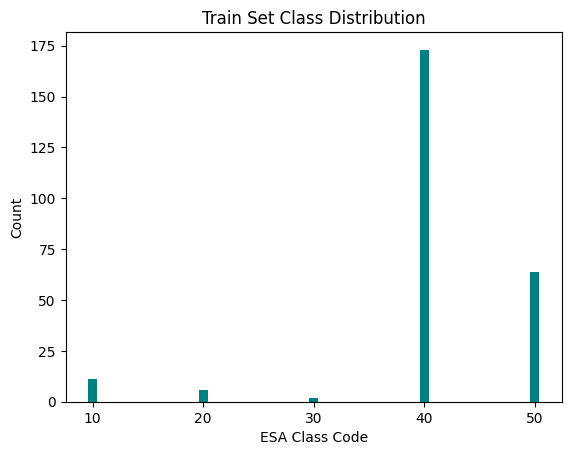

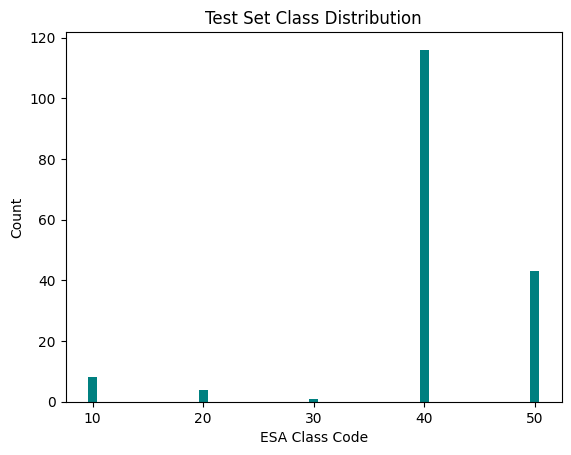

In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    patches, labels, test_size=0.4, stratify=labels, random_state=42
)

# Class distribution visualization
def plot_class_distribution(y, title):
    counts = Counter(y)
    classes = sorted(counts.keys())
    values = [counts[k] for k in classes]
    plt.bar(classes, values, color='teal')
    plt.xlabel("ESA Class Code")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(classes)
    plt.show()

plot_class_distribution(y_train, "Train Set Class Distribution")
plot_class_distribution(y_test, "Test Set Class Distribution")